<h1> Explore and create ML datasets </h1>

In this notebook, we will explore data corresponding to taxi rides in New York City to build a Machine Learning model in support of a fare-estimation tool. The idea is to suggest a likely fare to taxi riders so that they are not surprised, and so that they can protest if the charge is much higher than expected.

<div id="toc"></div>

Let's start off with the Python imports that we need.

In [1]:
!pip install --user google-cloud-bigquery==1.25.0

     |████████████████████████████████| 169 kB 7.0 MB/s            
     |████████████████████████████████| 93 kB 1.7 MB/s             
     |████████████████████████████████| 152 kB 46.9 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tfx 0.23.0 requires attrs<20,>=19.3.0, but you have attrs 21.2.0 which is incompatible.
tfx 0.23.0 requires click<8,>=7, but you have click 8.0.3 which is incompatible.
tfx 0.23.0 requires docker<5,>=4.1, but you have docker 5.0.3 which is incompatible.
tfx 0.23.0 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.31.0 which is incompatible.
tfx 0.23.0 requires google-resumable-media<0.7.0,>=0.6.0, but you have google-resumable-media 0.5.1 which is incompatible.
tfx 0.23.0 requires kubernetes<12,>=10.0.1,

**Note**: Restart your kernel to use updated packages.

Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

In [2]:
from google.cloud import bigquery
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

<h3> Extract sample data from BigQuery </h3>

The dataset that we will use is <a href="https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips">a BigQuery public dataset</a>. Click on the link, and look at the column names. Switch to the Details tab to verify that the number of records is one billion, and then switch to the Preview tab to look at a few rows.

Write a SQL query to pick up the following fields
<pre>
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
</pre>
from the dataset and explore a small part of the data. Make sure to pick a repeatable subset of the data so that if someone reruns this notebook, they will get the same results.

In [3]:
rawdata = """
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  `nyc-tlc.yellow.trips`
WHERE
  ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), EVERY_N)) = 1
"""

In [4]:
query = rawdata.replace("EVERY_N", "100000")
print(query)
trips = bigquery.Client().query(query).to_dataframe()
print("Total dataset is {} taxi rides".format(len(trips)))
trips[:10]


SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  `nyc-tlc.yellow.trips`
WHERE
  ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1

Total dataset is 10789 taxi rides


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2014-12-08 21:50:00+00:00,-73.994802,40.720612,-73.949125,40.668893,1,5.33,0.00,22.0,27.00
1,2012-03-04 00:57:00+00:00,-74.005625,40.734517,-73.952492,40.725197,1,7.33,0.00,20.5,23.50
2,2014-05-20 23:09:00+00:00,-73.995203,40.727307,-73.948775,40.813487,1,10.31,0.00,33.5,38.00
3,2014-04-30 16:45:10+00:00,-73.989434,40.756601,-73.949989,40.826892,1,6.20,0.00,24.5,31.20
4,2013-04-09 09:39:13+00:00,-73.981443,40.763466,-74.010072,40.704927,1,6.50,0.00,24.5,30.00
5,2014-04-19 14:08:46+00:00,-73.964716,40.773071,-73.997511,40.697289,1,8.70,0.00,26.5,33.75
6,2013-12-09 15:03:00+00:00,-73.990950,40.749772,-73.870807,40.774070,1,9.44,5.33,29.0,34.83
7,2014-10-06 15:16:00+00:00,-73.980130,40.760910,-73.861730,40.768330,2,11.47,5.33,36.5,47.33
8,2014-12-08 21:50:00+00:00,-73.870867,40.773782,-74.003297,40.708215,2,11.81,0.00,33.5,37.50
9,2010-05-26 16:15:03+00:00,-74.002922,40.714474,-73.978505,40.758280,1,6.10,0.00,20.9,25.76


<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. We'll use the Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering.

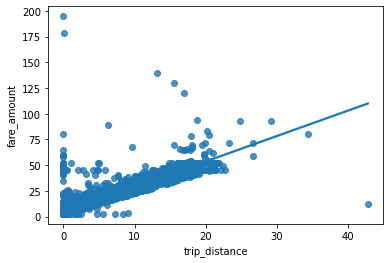

In [6]:
ax = sns.regplot(x = "trip_distance", y = "fare_amount", ci = None, truncate = True, data = trips)

Hmm ... do you see something wrong with the data that needs addressing?

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

What's up with the streaks at \$45 and \$50?  Those are fixed-amount rides from JFK and La Guardia airports into anywhere in Manhattan, i.e. to be expected. Let's list the data to make sure the values look reasonable.

Let's examine whether the toll amount is captured in the total amount.

In [7]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[tollrides['pickup_datetime'] == '2014-05-20 23:09:00']

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
83,2014-05-20 23:09:00+00:00,-73.873527,40.773922,-73.944947,40.828902,5,8.35,5.33,25.0,36.33
154,2014-05-20 23:09:00+00:00,-73.874567,40.774102,-73.986480,40.759202,1,11.43,5.33,37.0,54.04
300,2014-05-20 23:09:00+00:00,-73.870160,40.760742,-73.980912,40.788492,4,10.37,5.33,30.5,45.91
409,2014-05-20 23:09:00+00:00,-74.005625,40.736770,-73.919840,40.877687,1,14.33,2.44,42.0,54.43
1043,2014-05-20 23:09:00+00:00,0.000000,0.000000,0.000000,0.000000,1,6.38,5.33,20.0,26.33
1087,2014-05-20 23:09:00+00:00,-73.874445,40.774037,-73.982382,40.784930,1,9.97,5.33,30.5,44.10
1127,2014-05-20 23:09:00+00:00,-73.781987,40.644755,-73.921672,40.828412,1,19.08,5.33,50.5,56.83
1482,2014-05-20 23:09:00+00:00,-73.873210,40.774042,-73.978013,40.755800,5,10.45,5.33,30.5,36.83
1548,2014-05-20 23:09:00+00:00,-73.984350,40.761760,-73.859030,40.718510,2,10.04,5.33,31.5,37.83
4281,2014-05-20 23:09:00+00:00,-73.975610,40.751660,-73.953920,40.743240,1,2.22,5.33,8.5,14.83


Looking a few samples above, it should be clear that the total amount reflects fare amount, toll and tip somewhat arbitrarily -- this is because when customers pay cash, the tip is not known.  So, we'll use the sum of fare_amount + tolls_amount as what needs to be predicted.  Tips are discretionary and do not have to be included in our fare estimation tool.

Let's also look at the distribution of values within the columns.

In [8]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000
mean,-72.577466,39.988518,-72.577056,39.991694,1.648716,2.837068,0.228359,11.165192,13.280564
std,10.071200,5.523964,10.068592,5.510504,1.282589,3.319036,1.144977,9.444876,11.267704
min,-75.336579,0.000000,-75.381754,0.000000,0.000000,0.000000,0.000000,2.500000,2.500000
25%,-73.992172,40.735837,-73.991581,40.734267,1.000000,1.010000,0.000000,6.000000,7.200000
50%,-73.981871,40.753200,-73.980401,40.752872,1.000000,1.750000,0.000000,8.500000,10.000000
75%,-73.967330,40.767309,-73.964102,40.767484,2.000000,3.110000,0.000000,12.500000,14.600000
max,0.000000,41.366138,0.000000,41.366138,6.000000,42.800000,16.000000,194.750000,204.750000


Hmm ... The min, max of longitude look strange.

Finally, let's actually look at the start and end of a few of the trips.

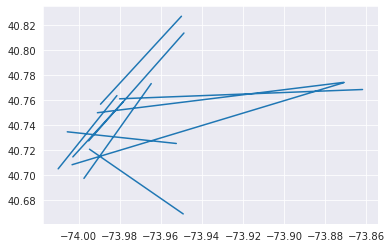

In [9]:
def showrides(df, numlines):
  import matplotlib.pyplot as plt
  lats = []
  lons = []
  goodrows = df[df['pickup_longitude'] < -70]
  for iter, row in goodrows[:numlines].iterrows():
    lons.append(row['pickup_longitude'])
    lons.append(row['dropoff_longitude'])
    lons.append(None)
    lats.append(row['pickup_latitude'])
    lats.append(row['dropoff_latitude'])
    lats.append(None)

  sns.set_style("darkgrid")
  plt.plot(lons, lats)

showrides(trips, 10)

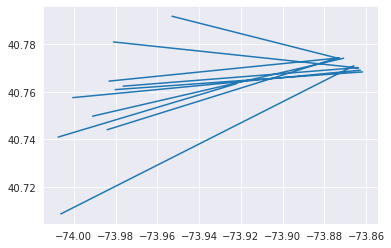

In [10]:
showrides(tollrides, 10)

As you'd expect, rides that involve a toll are longer than the typical ride.

<h3> Quality control and other preprocessing </h3>

We need to do some clean-up of the data:
<ol>
<li>New York city longitudes are around -74 and latitudes are around 41.</li>
<li>We shouldn't have zero passengers.</li>
<li>Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.</li>
<li>Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset</li>
<li>Discard the timestamp</li>
</ol>

Let's change the BigQuery query appropriately.  In production, we'll have to carry out the same preprocessing on the real-time input data. 

In [11]:
def sample_between(a, b):
    basequery = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
    sampler = "AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), EVERY_N)) = 1"
    sampler2 = "AND {0} >= {1}\n AND {0} < {2}".format(
           "ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), EVERY_N * 100))",
           "(EVERY_N * {})".format(a), "(EVERY_N * {})".format(b)
        )
    return "{}\n{}\n{}".format(basequery, sampler, sampler2)

def create_query(phase, EVERY_N):
  """Phase: train (70%) valid (15%) or test (15%)"""
  query = ""
  if phase == 'train':
    # Training
    query = sample_between(0, 70)
  elif phase == 'valid':
    # Validation
    query = sample_between(70, 85)
  else:
    # Test
    query = sample_between(85, 100)
  return query.replace("EVERY_N", str(EVERY_N))

print(create_query('train', 100000))


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  
AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1
AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000 * 100)) >= (100000 * 0)
 AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000 * 100)) < (100000 * 70)


In [12]:
def to_csv(df, filename):
  outdf = df.copy(deep = False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # Reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  cols.insert(0, 'fare_amount')
  print(cols)  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header = False, index_label = False, index = False)
  print("Wrote {} to {}".format(len(outdf), filename))

for phase in ['train', 'valid', 'test']:
  query = create_query(phase, 100000)
  df = bigquery.Client().query(query).to_dataframe()
  to_csv(df, 'taxi-{}.csv'.format(phase))

['fare_amount', 'pickuplon', 'pickuplat', 'dropofflon', 'dropofflat', 'passengers', 'key']
Wrote 7645 to taxi-train.csv
['fare_amount', 'pickuplon', 'pickuplat', 'dropofflon', 'dropofflat', 'passengers', 'key']
Wrote 1814 to taxi-valid.csv
['fare_amount', 'pickuplon', 'pickuplat', 'dropofflon', 'dropofflat', 'passengers', 'key']
Wrote 1017 to taxi-test.csv


<h3> Verify that datasets exist </h3>

In [13]:
!ls -l *.csv

-rw-r--r-- 1 jupyter jupyter  58048 Nov 28 06:04 taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 434648 Nov 28 06:03 taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 102591 Nov 28 06:03 taxi-valid.csv


We have 3 .csv files corresponding to train, valid, test.  The ratio of file-sizes correspond to our split of the data.

In [14]:
!head taxi-train.csv

5.0,-73.995835,40.74877,-73.98997,40.756574,1.0,0
5.0,-73.960482,40.778617,-73.94947,40.778617,1.0,1
7.0,-73.984035,40.749722,-73.981642,40.75244,2.0,2
41.83,-73.98013,40.76091,-73.86173,40.76833,2.0,3
33.5,-73.870867,40.773782,-74.003297,40.708215,2.0,4
10.1,-73.985472,40.747142,-73.987345,40.722432,1.0,5
6.0,-73.99081,40.734712,-73.998325,40.726196,1.0,6
6.5,-73.980577,40.742438,-73.981168,40.72925,1.0,7
6.5,-73.994098,40.751338,-73.978192,40.754195,1.0,8
8.0,-73.989793,40.741405,-74.003768,40.72233,1.0,9


Looks good! We now have our ML datasets and are ready to train ML models, validate them and evaluate them.

<h3> Benchmark </h3>

Before we start building complex ML models, it is a good idea to come up with a very simple model and use that as a benchmark.

My model is going to be to simply divide the mean fare_amount by the mean trip_distance to come up with a rate and use that to predict.  Let's compute the RMSE of such a model.

In [15]:
import pandas as pd
import numpy as np
import shutil

def distance_between(lat1, lon1, lat2, lon2):
  # Haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  dist = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual - predicted)**2))

def print_rmse(df, rate, name):
  print("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate * estimate_distance(df)), name))

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('taxi-train.csv', header = None, names = columns)
df_valid = pd.read_csv('taxi-valid.csv', header = None, names = columns)
df_test = pd.read_csv('taxi-test.csv', header = None, names = columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print("Rate = ${0}/km".format(rate))
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

Rate = $2.6164717532562003/km
Train RMSE = 7.459449828243709
Valid RMSE = 9.354082564704136
Test RMSE = 5.4447080496414655


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


The simple distance-based rule gives us a RMSE of <b>$9.35</b> on the validation dataset.  We have to beat this, of course, but you will find that simple rules of thumb like this can be surprisingly difficult to beat. You don't wnat to set a goal on the test dataset because you want to change the architecture of the network etc. to get the best validation error. Then, you can evaluate ONCE on the test data.

## Challenge Exercise

Let's say that you want to predict whether a Stackoverflow question will be acceptably answered. Using this [public dataset of questions](https://bigquery.cloud.google.com/table/bigquery-public-data:stackoverflow.posts_questions), create a machine learning dataset that you can use for classification.
<p>
What is a reasonable benchmark for this problem?
What features might be useful?
<p>
If you got the above easily, try this harder problem: you want to predict whether a question will be acceptably answered within 2 days. How would you create the dataset?
<p>
Hint (highlight to see):
<p style='color:white' linkstyle='color:white'> 
You will need to do a SQL join with the table of [answers]( https://bigquery.cloud.google.com/table/bigquery-public-data:stackoverflow.posts_answers) to determine whether the answer was within 2 days.
</p>

Copyright 2018 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.